This example simulates a shield room / bunker with corridor entrance a neutron source in the center of the room.

Variance reduction is used to accelerate the simulation.

The variance reduction method used for this simulation (survival_biasing) is not as effective as other variance reduction methods available in OpenMC but is the first task in the variance reduction section as it is the simplest to implement.

Openmc documentation on survival-biasing
https://docs.openmc.org/en/stable/methods/neutron_physics.html#survival-biasing


First we import openmc and other packages needed for the example

In [1]:
import openmc
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm  # used for plotting log scale graphs

We create a couple of materials for the simulation

In [3]:
mat_air = openmc.Material(name="Air")
mat_air.add_element("N", 0.784431)
mat_air.add_element("O", 0.210748)
mat_air.add_element("Ar", 0.0046)
mat_air.set_density("g/cc", 0.001205)

mat_concrete = openmc.Material()
mat_concrete.add_element("H",0.168759)
mat_concrete.add_element("C",0.001416)
mat_concrete.add_element("O",0.562524)
mat_concrete.add_element("Na",0.011838)
mat_concrete.add_element("Mg",0.0014)
mat_concrete.add_element("Al",0.021354)
mat_concrete.add_element("Si",0.204115)
mat_concrete.add_element("K",0.005656)
mat_concrete.add_element("Ca",0.018674)
mat_concrete.add_element("Fe",0.00426)
mat_concrete.set_density("g/cm3", 2.3)

materials = openmc.Materials([mat_air, mat_concrete])

Now we define and plot the geometry. This geometry is define by parameters for every width and height. The parameters input into the geometry in a stacked manner so they can easily be adjusted to change the geometry without creating overlapping cells.

In [5]:

width_a = 100
width_b = 200
width_c = 500
width_d = 250
width_e = 200
width_f = 200
width_g = 100

depth_a = 100
depth_b = 200
depth_c = 700
depth_d = 600
depth_e = 200
depth_f = 100

height_j = 100
height_k = 500
height_l = 100

xplane_0 = openmc.XPlane(x0=0, boundary_type="vacuum")
xplane_1 = openmc.XPlane(x0=xplane_0.x0 + width_a)
xplane_2 = openmc.XPlane(x0=xplane_1.x0 + width_b)
xplane_3 = openmc.XPlane(x0=xplane_2.x0 + width_c)
xplane_4 = openmc.XPlane(x0=xplane_3.x0 + width_d)
xplane_5 = openmc.XPlane(x0=xplane_4.x0 + width_e)
xplane_6 = openmc.XPlane(x0=xplane_5.x0 + width_f)
xplane_7 = openmc.XPlane(x0=xplane_6.x0 + width_g, boundary_type="vacuum")

yplane_0 = openmc.YPlane(y0=0, boundary_type="vacuum")
yplane_1 = openmc.YPlane(y0=yplane_0.y0 + depth_a)
yplane_2 = openmc.YPlane(y0=yplane_1.y0 + depth_b)
yplane_3 = openmc.YPlane(y0=yplane_2.y0 + depth_c)
yplane_4 = openmc.YPlane(y0=yplane_3.y0 + depth_d)
yplane_5 = openmc.YPlane(y0=yplane_4.y0 + depth_e)
yplane_6 = openmc.YPlane(y0=yplane_5.y0 + depth_f, boundary_type="vacuum")

zplane_1 = openmc.ZPlane(z0=0, boundary_type="vacuum")
zplane_2 = openmc.ZPlane(z0=zplane_1.z0 + height_j)
zplane_3 = openmc.ZPlane(z0=zplane_2.z0 + height_k)
zplane_4 = openmc.ZPlane(z0=zplane_3.z0 + height_l, boundary_type="vacuum")

outside_left_region = +xplane_0 & -xplane_1 & +yplane_1 & -yplane_5 & +zplane_1 & -zplane_4
wall_left_region = +xplane_1 & -xplane_2 & +yplane_2 & -yplane_4 & +zplane_2 & -zplane_3
wall_right_region = +xplane_5 & -xplane_6 & +yplane_2 & -yplane_5 & +zplane_2 & -zplane_3
wall_top_region = +xplane_1 & -xplane_4 & +yplane_4 & -yplane_5 & +zplane_2 & -zplane_3
outside_top_region = +xplane_0 & -xplane_7 & +yplane_5 & -yplane_6 & +zplane_1 & -zplane_4
wall_bottom_region = +xplane_1 & -xplane_6 & +yplane_1 & -yplane_2 & +zplane_2 & -zplane_3
outside_bottom_region = +xplane_0 & -xplane_7 & +yplane_0 & -yplane_1 & +zplane_1 & -zplane_4
wall_middle_region = +xplane_3 & -xplane_4 & +yplane_3 & -yplane_4 & +zplane_2 & -zplane_3
outside_right_region = +xplane_6 & -xplane_7 & +yplane_1 & -yplane_5 & +zplane_1 & -zplane_4

room_region = +xplane_2 & -xplane_3 & +yplane_2 & -yplane_4 & +zplane_2 & -zplane_3
gap_region = +xplane_3 & -xplane_4 & +yplane_2 & -yplane_3 & +zplane_2 & -zplane_3
corridor_region = +xplane_4 & -xplane_5 & +yplane_2 & -yplane_5 & +zplane_2 & -zplane_3

roof_region = +xplane_1 & -xplane_6 & +yplane_1 & -yplane_5 & +zplane_1 & -zplane_2
floor_region = +xplane_1 & -xplane_6 & +yplane_1 & -yplane_5 & +zplane_3 & -zplane_4

outside_left_cell = openmc.Cell(region=outside_left_region, fill=mat_air)
outside_right_cell = openmc.Cell(region=outside_right_region, fill=mat_air)
outside_top_cell = openmc.Cell(region=outside_top_region, fill=mat_air)
outside_bottom_cell = openmc.Cell(region=outside_bottom_region, fill=mat_air)
wall_left_cell = openmc.Cell(region=wall_left_region, fill=mat_concrete)
wall_right_cell = openmc.Cell(region=wall_right_region, fill=mat_concrete)
wall_top_cell = openmc.Cell(region=wall_top_region, fill=mat_concrete)
wall_bottom_cell = openmc.Cell(region=wall_bottom_region, fill=mat_concrete)
wall_middle_cell = openmc.Cell(region=wall_middle_region, fill=mat_concrete)
room_cell = openmc.Cell(region=room_region, fill=mat_air)
gap_cell = openmc.Cell(region=gap_region, fill=mat_air)
corridor_cell = openmc.Cell(region=corridor_region, fill=mat_air)

roof_cell = openmc.Cell(region=roof_region, fill=mat_concrete)
floor_cell = openmc.Cell(region=floor_region, fill=mat_concrete)

geometry = openmc.Geometry(
    [
        outside_bottom_cell,
        outside_top_cell,
        outside_left_cell,
        outside_right_cell,
        wall_left_cell,
        wall_right_cell,
        wall_top_cell,
        wall_bottom_cell,
        wall_middle_cell,
        room_cell,
        gap_cell,
        corridor_cell,
        roof_cell,
        floor_cell,
    ]
)


Now we plot the geometry and color by materials.

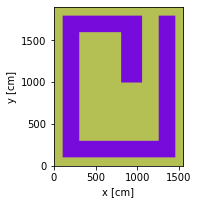

In [6]:

geometry.root_universe.plot(basis='xy', color_by='material') 
plt.savefig('geometry_top_down_view.png', bbox_inches="tight")

Next we create a point source, this also uses the same geometry parameters to place in the center of the room regardless of the values of the parameters.

In [7]:
# location of the point source
source_x = width_a + width_b + width_c * 0.5
source_y = depth_a + depth_b + depth_c * 0.75
source_z = height_j + height_k * 0.5
space = openmc.stats.Point((source_x, source_y, source_z))

angle = openmc.stats.Isotropic()

# all (100%) of source particles are 2.5MeV energy
energy = openmc.stats.Discrete([2.5e6], [1.0])

source = openmc.Source(space=space, angle=angle, energy=energy)
source.particle = "neutron"


Create a mesh that encompasses the entire geoemtry and scores neutron flux

In [8]:
mesh = openmc.RegularMesh().from_domain(geometry)
mesh.dimension = (100, 100, 1)

mesh_filter = openmc.MeshFilter(mesh)
particle_filter = openmc.ParticleFilter('neutron')

flux_tally = openmc.Tally(name="flux tally")
flux_tally.filters = [mesh_filter, particle_filter]
flux_tally.scores = ["flux"]

tallies = openmc.Tallies([flux_tally])

Creates the simulation settings

In [9]:
settings = openmc.Settings()

settings.run_mode = "fixed source"
settings.source = source
settings.particles = 2000
settings.batches = 5

Creates the model

In [10]:
model = openmc.Model(geometry, materials, settings, tallies)

We are going to run this model twice. Once with survival_biasing and once without. This next code bock makes a function so that we can easily run the simulation twice with these two different settings.

In [16]:
def run_and_plot(model, image_filename):

    sp_filename = model.run()

    with openmc.StatePoint(sp_filename) as sp:
        flux_tally = sp.get_tally(name="flux tally")

    mesh_extent = mesh.bounding_box.extent['xy']

    # create a plot of the mean flux values
    flux_mean = flux_tally.get_reshaped_data(value='mean', expand_dims=True).squeeze()
    plt.subplot(1, 2, 1)
    plt.imshow(
        flux_mean,
        origin="lower",
        extent=mesh_extent,
        norm=LogNorm(),
    )
    plt.title("Flux Mean")


    plt.subplot(1, 2, 2)
    # create a plot of the flux relative error
    flux_std_dev = flux_tally.get_reshaped_data(value='std_dev', expand_dims=True).squeeze()
    plt.imshow(
        flux_std_dev,
        origin="lower",
        extent=mesh_extent,
        norm=LogNorm(),
    )
    plt.title("Flux Std. Dev.")

    plt.savefig(image_filename)
    return sp

Now we run the model without survival_biasing and save the meesh tally image

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

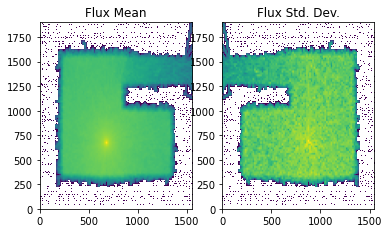

In [17]:

run_and_plot(model, "no_survival_biasing.png")


Now we run the model again with survival_biasing enabled. This needs to me set on the model settings. The values chosen can be fine tunned to the model but for this example we have chosen some values after a little exploration.

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

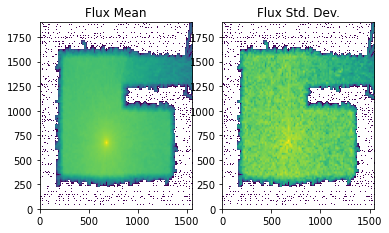

In [15]:

model.settings.survival_biasing = True
model.settings.cutoff = {
    "weight": 0.3,  # value needs to be between 0 and 1
    "weight_avg": 0.9,  # value needs to be between 0 and 1
}
run_and_plot(model, "yes_survival_biasing.png")


Comparing the two simulations we notice that the survival_biasing simulation resulted in slightly improved flux tally and a slightly improved standard deviation.

This model is used again in the next example that makes use of weight windows and yields more impressive acceleration. 